In [34]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL
import cv2

In [35]:
from fvcore.nn import FlopCountAnalysis


In [36]:
device = torch.device("cpu")

In [37]:
input_count = 1

In [38]:
def get_sample_image(filename)-> PIL.Image.Image:
    #filename = '/home/sayan/Downloads/cylinder_mach.jpg'
    #filename = '/home/sayan/Downloads/flow_visualization.jpg'
    #filenmame1 = '/home/sayan/Downloads/flow_visualization_square.jpg'
    return PIL.Image.open(filename)

In [39]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [40]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [41]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        
        """
        if 
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]
            
        
        """ 
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)
            
        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        
        return mean + variance, noise.to(device)
    
    @torch.no_grad()
    def backward(self, x, t, model,geometry = None, **kwargs):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        
        predicted_noise = model(x, t, geometry, **kwargs)

        mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if 
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3
            
        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)
        
        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
        
        

In [42]:
#IMAGE_SHAPE = (32, 32)
IMAGE_SHAPE = (64, 64)
#IMAGE_SHAPE = (128, 128)

In [43]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1] 
])


reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),  # Scale to [0, 1]
    transforms.Lambda(lambda t: t.clamp(0, 1)),  # Ensure values stay in [0, 1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
    transforms.Lambda(lambda t: torch.nan_to_num(t, nan=0.0, posinf=1.0, neginf=0.0)),  # Clean NaNs/Infs
    transforms.Lambda(lambda t: (t * 255).cpu().numpy().astype(np.uint8)),  # Convert to [0, 255] uint8
    transforms.ToPILImage(),  # Convert to PIL
])


In [44]:
file_list = []
torch_list = []

for i in range(1, input_count+1):
    flname = f"/home/sayan/Downloads/flimg_{i}.jpg"
    file_list.append(flname)
    pil_image = get_sample_image(flname)
    torch_image = transform(pil_image)
    torch_list.append(torch_image)

In [45]:
diffusion_model = DiffusionModel()

In [46]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [47]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()
        
        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)
        
        self.downsample = downsample
        
        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)
            
        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)
        
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]
            
        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

In [48]:
def get_2d_sinusoidal_positional_encoding(H, W, embed_dim):
    if embed_dim % 4 != 0:
        raise ValueError("Embed dim must be divisible by 4 for 2D sin encoding.")

    pe = torch.zeros(H, W, embed_dim)
    div_term = torch.exp(torch.arange(0, embed_dim // 2, 2) * -(math.log(10000.0) / (embed_dim // 2)))

    pos_y = torch.arange(0, H).unsqueeze(1)
    pos_x = torch.arange(0, W).unsqueeze(1)

    pe[:, :, 0::4] = torch.sin(pos_x * div_term)
    pe[:, :, 1::4] = torch.cos(pos_x * div_term)
    pe[:, :, 2::4] = torch.sin(pos_y * div_term)
    pe[:, :, 3::4] = torch.cos(pos_y * div_term)

    return pe.view(H * W, embed_dim)  # Flatten to match (H*W, embed_dim)


In [49]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim):
        super(CrossAttention, self).__init__()
        self.attention_layer = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=4)
        self.embed_dim = embed_dim

        # To project both flow features and geometry features to same dimension
        self.flow_proj = nn.Conv2d(embed_dim, embed_dim, 1)
        self.geometry_proj = nn.Conv2d(1, embed_dim, 1)  # From grayscale geometry prompt

    def forward(self, x, geometry, return_attention=False):
        B, C, H, W = x.shape
        x_proj = self.flow_proj(x)  # shape: [B, C, H, W]
        g_proj = self.geometry_proj(geometry)  # shape: [B, C, H, W]

        # Flatten to sequences for attention
        x_seq = x_proj.flatten(2).transpose(1, 2)  # [B, HW, C]
        g_seq = g_proj.flatten(2).transpose(1, 2)  # [B, HW, C]

        # Positional encoding (optional)
        pe = get_2d_sinusoidal_positional_encoding(H, W, self.embed_dim).to(x_seq.device)  # [H*W, C]
        pe = pe.unsqueeze(0).repeat(B, 1, 1)  # [B, H*W, C]
        x_seq = x_seq + pe  # [B, H*W, C]
        # x_seq = x_seq + ... (add if you want 2D pos encodings)

        # Apply cross-attention: query=x, key=geometry, value=geometry
        attn_output, attn_weights = self.attention_layer(query=x_seq, key=g_seq, value=g_seq)
        attn_output = attn_output.transpose(1, 2).view(B, C, H, W)

        if return_attention:
            return attn_output, attn_weights  # attn_weights shape: [B, num_heads, HW, HW]
        return attn_output


In [50]:
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)
        
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)
        self.cross_attention = CrossAttention(embed_dim=sequence_channels[-1])  # removed geometry_dim
        #self.cross_attention = CrossAttention(geometry_dim=128, embed_dim=sequence_channels[-1])

    
    def forward(self, x, t, geometry, return_attention=False, **kwargs):
        residuals = []
        o = self.conv1(x)

        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)

        if return_attention:
            o, attn_weights = self.cross_attention(o, geometry, return_attention=True)
        else:
            o = self.cross_attention(o, geometry)

        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)

        if return_attention:
            return self.conv2(o), attn_weights
        else:
            return self.conv2(o)


In [51]:
geometry_list = []

In [52]:
'''# Define a more flexible geometry encoder
class GeometryEncoder(nn.Module):
    def __init__(self, output_dim=128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    '''

'# Define a more flexible geometry encoder\nclass GeometryEncoder(nn.Module):\n    def __init__(self, output_dim=128):\n        super().__init__()\n        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)\n        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)\n        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)\n        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))\n        self.fc = nn.Linear(128, output_dim)\n\n    def forward(self, x):\n        x = torch.relu(self.conv1(x))\n        x = torch.relu(self.conv2(x))\n        x = torch.relu(self.conv3(x))\n        x = self.adaptive_pool(x)\n        x = x.view(x.size(0), -1)\n        return self.fc(x)\n    '

In [53]:
from PIL import Image
import torchvision.transforms as T

def load_geometry_prompt(path, H, W):
    img = Image.open(path).convert('L')
    transform = T.Compose([
        T.Resize((H, W)),
        T.ToTensor(),
    ])
    prompt = transform(img)  # shape: [1, H, W]
    prompt = 1.0 - prompt  # make obstacle = 1, background = 0
    return prompt.unsqueeze(0)  # shape: [1, 1, H, W]


In [54]:

for i in range(1, input_count+1):
    image_path = f"/home/sayan/Downloads/prpt_{i}.jpg"
    _, H, W = torch_list[i-1].shape
    geometric_prompt = load_geometry_prompt(image_path, H, W)
    geometry_list.append(geometric_prompt)
    print("Encoded Geometry Prompt Shape:", geometric_prompt.shape)

    #batch_size = 4
    #geometry = geometric_prompt.repeat(batch_size, 1)  # Shape: (B, 128)
    #print("Final Geometry Shape:", geometry.shape)


Encoded Geometry Prompt Shape: torch.Size([1, 1, 64, 64])


In [55]:
NO_EPOCHS = 600
PRINT_FREQUENCY = 100
LR = 0.001
BATCH_SIZE = 4
VERBOSE = True

unet = UNet(labels=False)

unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [56]:
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        B, C, H, W = x.shape
        t = torch.randint(0, 1000, (B,), device = x.device)
        geometry = torch.randn(B, 1, H, W, device = x.device)
        return self.model(x, t, geometry)

In [57]:
modelflop = UNet(labels=False)
wrappedmodel = WrappedModel(modelflop)
input_tensor = torch.randn(1, 3, 64, 64)
flops = FlopCountAnalysis(wrappedmodel, input_tensor)
print("Total Flops per forward pass found using FlopCountAnalysis = ", flops.total()/1e9, "GFLOPs")

Unsupported operator aten::randint encountered 1 time(s)
Unsupported operator aten::randn encountered 1 time(s)
Unsupported operator aten::mul encountered 26 time(s)
Unsupported operator aten::exp encountered 9 time(s)
Unsupported operator aten::sin encountered 10 time(s)
Unsupported operator aten::cos encountered 10 time(s)
Unsupported operator aten::add encountered 9 time(s)
Unsupported operator aten::repeat encountered 1 time(s)
Unsupported operator aten::add_ encountered 3 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
model.cross_attention.attention_layer.out_proj


Total Flops per forward pass found using FlopCountAnalysis =  14.393171968 GFLOPs


In [22]:

#import matplotlib.pyplot as plt

'''def visualize_attention_map(attn_weights, sample_idx=0, head=0, H=64, W=64):
    """
    attn_weights: shape (num_heads * B, target_len, source_len)
    """
    num_heads = attn_weights.shape[0] // BATCH_SIZE
    attn = attn_weights[sample_idx * num_heads + head]  # Shape: (H*W, H*W)
    attn = attn.view(H, W, H, W).mean(dim=-1).mean(dim=-1)  # Spatial average

    plt.imshow(attn.cpu().detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title(f"Attention Map (Sample {sample_idx}, Head {head})")
    plt.show()'''
#def visualize_attention_map(attn_weights, sample_idx=0, head=0, H=64, W=64):
#    attn = attn_weights[sample_idx, head]  # [HW_query, HW_key]
#    attn_map = attn.mean(dim=1).reshape(H, W)  # Average attention weights across all geometry pixels
#    plt.imshow(attn_map.cpu().detach().numpy(), cmap='viridis')
#    plt.title(f"Attention Map - Sample {sample_idx}, Head {head}")
#    plt.colorbar()
#    plt.axis('off')
#    plt.show()



'def visualize_attention_map(attn_weights, sample_idx=0, head=0, H=64, W=64):\n    """\n    attn_weights: shape (num_heads * B, target_len, source_len)\n    """\n    num_heads = attn_weights.shape[0] // BATCH_SIZE\n    attn = attn_weights[sample_idx * num_heads + head]  # Shape: (H*W, H*W)\n    attn = attn.view(H, W, H, W).mean(dim=-1).mean(dim=-1)  # Spatial average\n\n    plt.imshow(attn.cpu().detach().numpy(), cmap=\'viridis\')\n    plt.colorbar()\n    plt.title(f"Attention Map (Sample {sample_idx}, Head {head})")\n    plt.show()'

In [23]:
print("Encoded Geometry Prompt Shape:", geometric_prompt.shape)

Encoded Geometry Prompt Shape: torch.Size([1, 1, 128, 128])


In [24]:
loss_train = []

---
Epoch: 0 | Train Loss 1.0330854654312134


<Figure size 1500x1500 with 0 Axes>

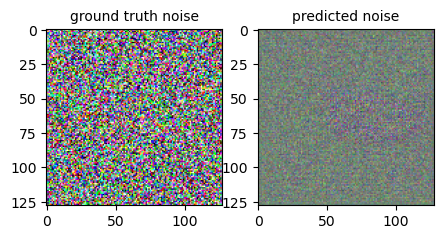

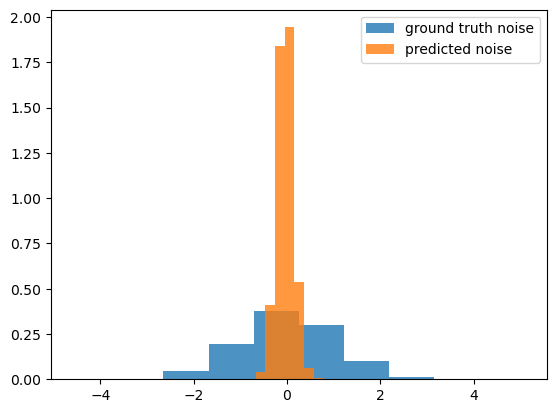

---
Epoch: 100 | Train Loss 0.028803011402487755


<Figure size 1500x1500 with 0 Axes>

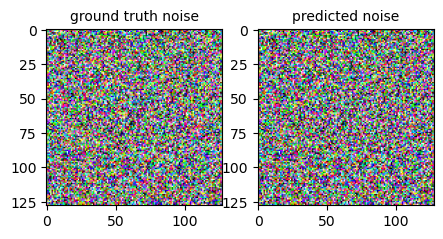

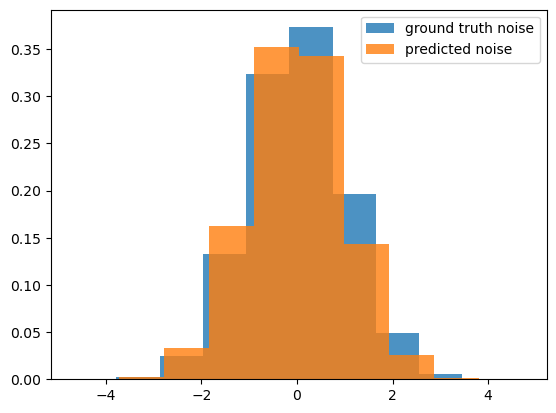

---
Epoch: 200 | Train Loss 0.010544187389314175


<Figure size 1500x1500 with 0 Axes>

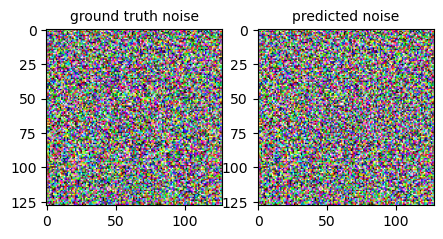

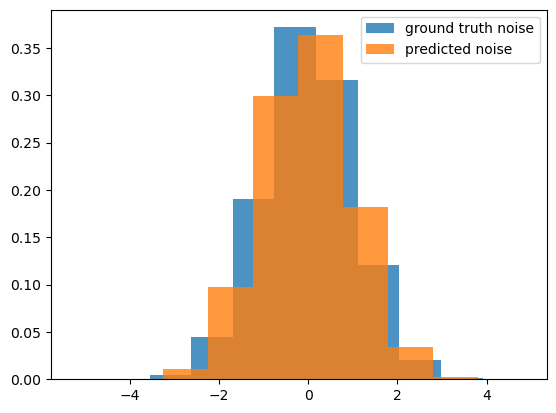

---
Epoch: 300 | Train Loss 0.005726023111492395


<Figure size 1500x1500 with 0 Axes>

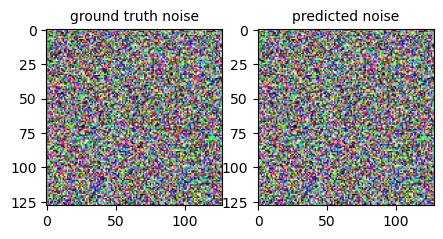

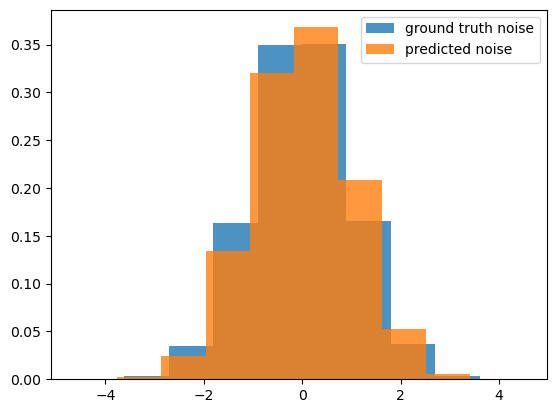

---
Epoch: 400 | Train Loss 0.027404367923736572


<Figure size 1500x1500 with 0 Axes>

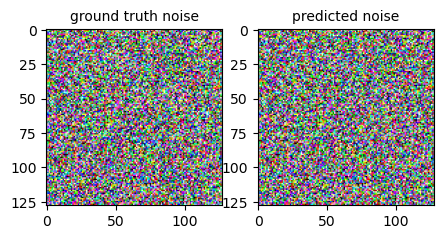

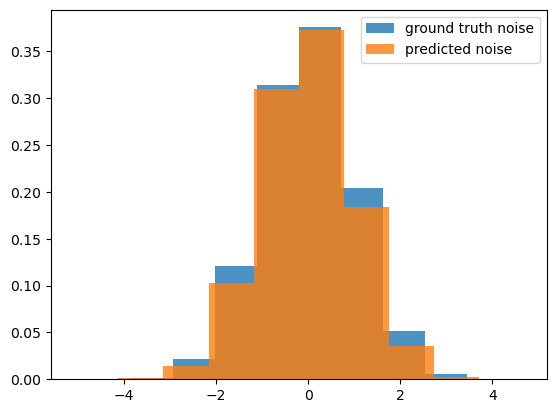

---
Epoch: 500 | Train Loss 0.017721211537718773


<Figure size 1500x1500 with 0 Axes>

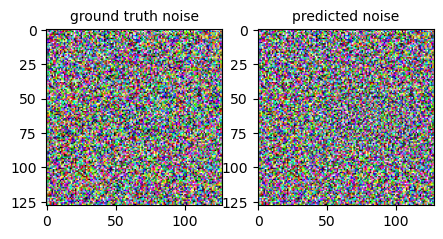

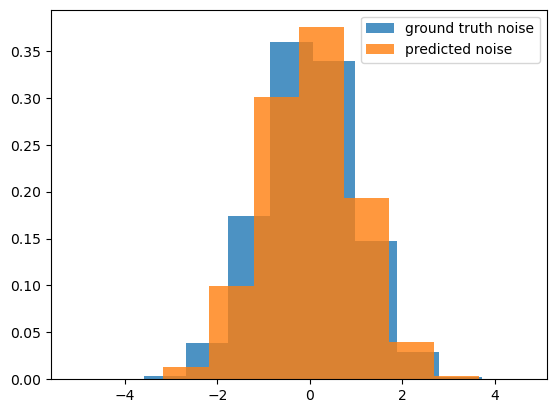

In [25]:
for epoch in range(NO_EPOCHS):
    for i in range(0, input_count):
        mean_epoch_loss = []
    
        batch = torch.stack([torch_list[i]] * BATCH_SIZE)
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)

        batch_noisy, noise = diffusion_model.forward(batch, t, device) 
        geometry_batch = geometry_list[i].repeat(BATCH_SIZE, 1, 1, 1).to(device)
        predicted_noise, attn_weights = unet(batch_noisy, t, geometry_batch, return_attention=True)
    
        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        #if epoch % PRINT_FREQUENCY == 0 and i == 0:
            #with torch.no_grad():
                #_, attn_weights = unet(batch_noisy, t, geometry_list[i], return_attention=True)
                #visualize_attention_map(attn_weights, sample_idx=0, head=0, H=64, W=64)
                
        #or (epoch % PRINT_FREQUENCY != 0 and epoch<50)
        if i==0:
            loss_train.append(np.mean(mean_epoch_loss))
        if epoch % PRINT_FREQUENCY == 0 and i==0:
            print('---')
            print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
            if VERBOSE:
                with torch.no_grad():
                    plot_noise_prediction(noise[0], predicted_noise[0])
                    plot_noise_distribution(noise, predicted_noise)
        

In [26]:
image_path = f"/home/sayan/Downloads/prpt_21.jpg"
_, H, W = torch_list[i].shape
geometric_prompt = load_geometry_prompt(image_path, H, W)
geometry_list.append(geometric_prompt)
print("Encoded Geometry Prompt Shape:", geometric_prompt.shape)


Encoded Geometry Prompt Shape: torch.Size([1, 1, 128, 128])


In [ ]:

with torch.no_grad():
    img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)
    
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        
        # Pass the geometric prompt here
        img = diffusion_model.backward(img, t, unet.eval(), geometry=geometric_prompt)
        
        if i % 50 == 0:
            plt.figure(figsize=(2, 2))
            plt.imshow(reverse_transform(img[0]))  # Convert tensor to image
            #filename = f"128pixel_regenerate_with_positional_encoding_visualize_geometry_with_much_high_epoch_prmpt{i}.png"
            filename = f"64pixel_trained_with_20_inputs_with_800epochs.png"
            plt.savefig(filename)
            #plt.axis('off')
            plt.show()


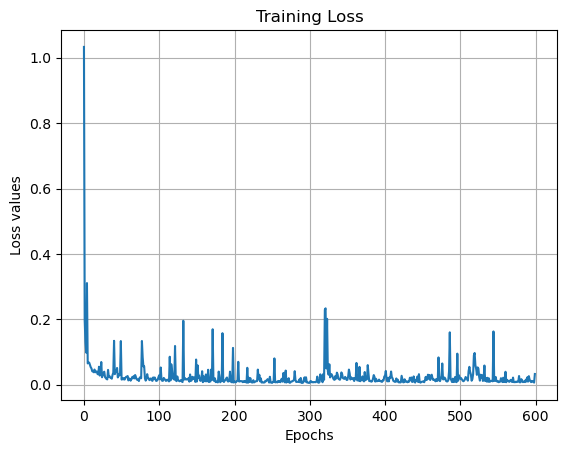

In [28]:
plt.plot(loss_train)
plt.xlabel("Epochs")
plt.ylabel("Loss values")
plt.title("Training Loss")
plt.grid(True)
filename = "training_loss_plot_128pixel_with_20_inputs_for_800epochs.jpg"
plt.savefig(filename)
plt.show()

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming loss_train is your list with 1000 values
loss_array = np.array(loss_train)

# Make sure the length is divisible by 10
#assert len(loss_array) == 1000, "Expected 800 loss values."

# Reshape and average every 10 values
loss_avg = loss_array.reshape(80, 10).mean(axis=1)

# Plot the result
plt.plot(range(1, 81), loss_avg)
plt.xlabel("Epochs (Grouped in 10s)")
plt.ylabel("Average Loss")
plt.title("Smoothed Training Loss")
plt.grid(True)
filename = "training_loss_plot_128pixel_with_20_inputs_for_800epochs_smoothened.jpg"
plt.savefig(filename)
plt.show()


ValueError: cannot reshape array of size 600 into shape (80,10)